In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


**Fetching Data From Kaggle**

Loading data from kaggle to drive and unzipping it.<br>
A kaggle.json file is required for authentication.

In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d yelp-dataset/yelp-dataset 
!unzip yelp-dataset.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
Archive:  drive/MyDrive/IST718/Project/yelp-dataset.zip
  inflating: Dataset_User_Agreement.pdf  
  inflating: yelp_academic_dataset_business.json  
  inflating: yelp_academic_dataset_checkin.json  
  inflating: yelp_academic_dataset_review.json  
  i

**Installing the Spark Library**

In [4]:
%%bash
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=529882f2c4a2eb518557d938f89eff7b4017d9e72503f306bcf8fdf33d623f2a
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


**Importing required Libraries**

In [5]:
%matplotlib inline
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType, StructField, StringType, MapType
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from pyspark.ml.feature import Tokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.sql.functions import lower, regexp_replace

In [6]:
sns.set_theme(style="whitegrid", palette="pastel")

**Creating Spark Session**

In [7]:
# conf = SparkConf().set("spark.kryoserializer.buffer.max", "4g")
spark = SparkSession.builder.getOrCreate()
spark_context = spark.sparkContext
sqlContext = SQLContext(spark_context)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# **Data Loading**

## **Reviews Dataset**

In [43]:
reviews = spark.read.json('yelp_academic_dataset_review.json')

In [44]:
reviews.show(5)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

In [45]:
columns_to_drop = ['cool','funny','average_stars']
reviews = reviews.drop(*columns_to_drop)

## **Businesses Dataset**

In [8]:
businesses = spark.read.json('yelp_academic_dataset_business.json')

In [12]:
businesses.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{null, null, null...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                null|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{null, null, null...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

In [9]:
#change name for starts to avoid duplicates
businesses=businesses.withColumnRenamed("stars", "Restaurant_stars")
businesses=businesses.withColumnRenamed("name", "Restaurant_name")
businesses=businesses.withColumnRenamed("review_count", "Restaurant_review_count")

#only keep restaurant in business table for this project
businesses=businesses.filter(F.col('categories').rlike('Restaurants'))

In [14]:
businesses.count()

52268

In [10]:
columns_to_drop = ['postal_code']
businesses = businesses.drop(*columns_to_drop)

In [16]:
# businesses = businesses.filter(col("categories").contains("Restaurants"))
# businesses = businesses.filter(F.col("is_open").contains("1"))

## **Users Dataset**

In [17]:
users = spark.read.json('yelp_academic_dataset_user.json')

In [18]:
users.show(5)

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer| cool|               elite|fans|             friends|funny|  name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+-----+--------------------+----+--------------------+-----+------+------------+------+--------------------+-------------------+
|         3.91|    

In [19]:
columns_to_drop = ['elite','useful','yelping_since']
users = users.drop(*columns_to_drop)

In [20]:
users=users.withColumnRenamed("name", "user_name")

## **Exploration and Data Joining**

In [21]:
reviews.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [22]:
businesses.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [23]:
users.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- user_id: string (nullable = true)



In [24]:
df = reviews.join(businesses,on ='business_id', how = 'inner')
df = df.join(users,on ='user_id', how = 'inner')

In [25]:
# df.show(3) # Takes a lot of time to execute

# **Data Cleaning**

In [26]:
df.count()

4724464

In [27]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 

In [28]:
df.describe()

DataFrame[summary: string, user_id: string, business_id: string, date: string, review_id: string, stars: string, text: string, useful: string, address: string, categories: string, city: string, is_open: string, latitude: string, longitude: string, Restaurant_name: string, Restaurant_review_count: string, Restaurant_stars: string, state: string, average_stars: string, compliment_cool: string, compliment_cute: string, compliment_funny: string, compliment_hot: string, compliment_list: string, compliment_more: string, compliment_note: string, compliment_photos: string, compliment_plain: string, compliment_profile: string, compliment_writer: string, cool: string, fans: string, friends: string, funny: string, user_name: string, review_count: string]

## Dropping Columns


In [29]:
# friends do not provide any information and Restaurant_starts and hours are redudant information
columns_drop = ['friends', 'Restaurant_stars', 'hours']
df = df.drop(*columns_drop)

In [30]:
columns_drop = [
    'compliment_cute',
    'compliment_funny', 
    'compliment_hot', 
    'compliment_list',
    'compliment_more',
    'compliment_note', 
    'compliment_photos',
    'compliment_plain',
    'compliment_profile',
    'compliment_writer'
    ]
df = df.drop(*columns_drop)

## **Checking Null Values**

In [31]:
df.dropna().count()

4719396

In [32]:
df = df.dropna()

## **Type Casting**

In [33]:
import datetime
from pyspark.sql.functions import month

In [34]:
df = df.withColumn('date', F.to_date(F.unix_timestamp('date', 'yyyy-MM-dd HH:mm:ss').cast('timestamp')))
df = df.withColumn('year', F.year(F.col('date')))
df = df.withColumn('stars', df['stars'].cast('int'))

In [35]:
df.dtypes

[('user_id', 'string'),
 ('business_id', 'string'),
 ('date', 'date'),
 ('review_id', 'string'),
 ('stars', 'int'),
 ('text', 'string'),
 ('useful', 'bigint'),
 ('address', 'string'),
 ('attributes',
  'struct<AcceptsInsurance:string,AgesAllowed:string,Alcohol:string,Ambience:string,BYOB:string,BYOBCorkage:string,BestNights:string,BikeParking:string,BusinessAcceptsBitcoin:string,BusinessAcceptsCreditCards:string,BusinessParking:string,ByAppointmentOnly:string,Caters:string,CoatCheck:string,Corkage:string,DietaryRestrictions:string,DogsAllowed:string,DriveThru:string,GoodForDancing:string,GoodForKids:string,GoodForMeal:string,HairSpecializesIn:string,HappyHour:string,HasTV:string,Music:string,NoiseLevel:string,Open24Hours:string,OutdoorSeating:string,RestaurantsAttire:string,RestaurantsCounterService:string,RestaurantsDelivery:string,RestaurantsGoodForGroups:string,RestaurantsPriceRange2:string,RestaurantsReservations:string,RestaurantsTableService:string,RestaurantsTakeOut:string,Smoki

# **EDA**

## Unique Users By State

In [36]:
unique_users_per_state = df.groupBy('state').agg(F.countDistinct('user_id').alias('unique_users')).orderBy('unique_users', ascending=False)
pandas_df = unique_users_per_state.toPandas()

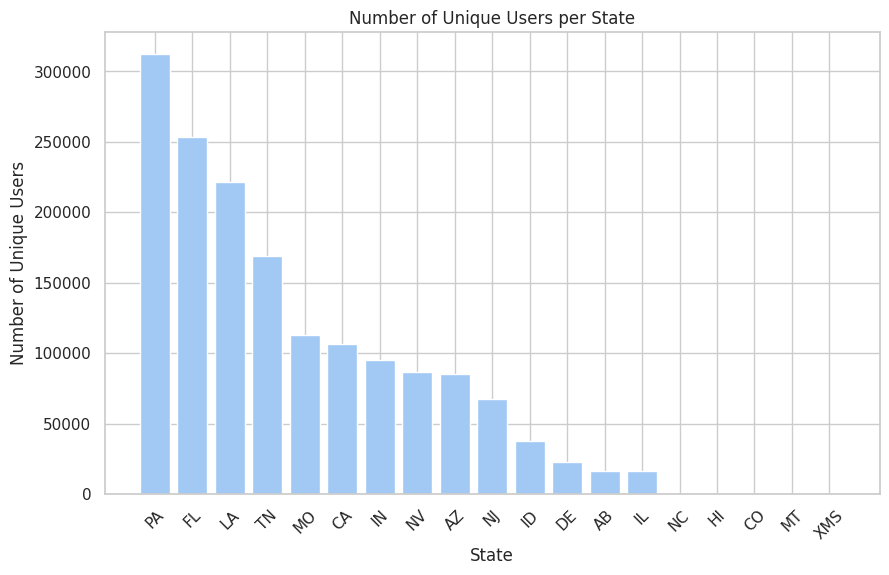

In [37]:
# Plot the number of unique users per state
plt.figure(figsize=(10, 6))
plt.bar(pandas_df['state'], pandas_df['unique_users'])
plt.xlabel('State')
plt.ylabel('Number of Unique Users')
plt.title('Number of Unique Users per State')
plt.xticks(rotation=45)
plt.show()

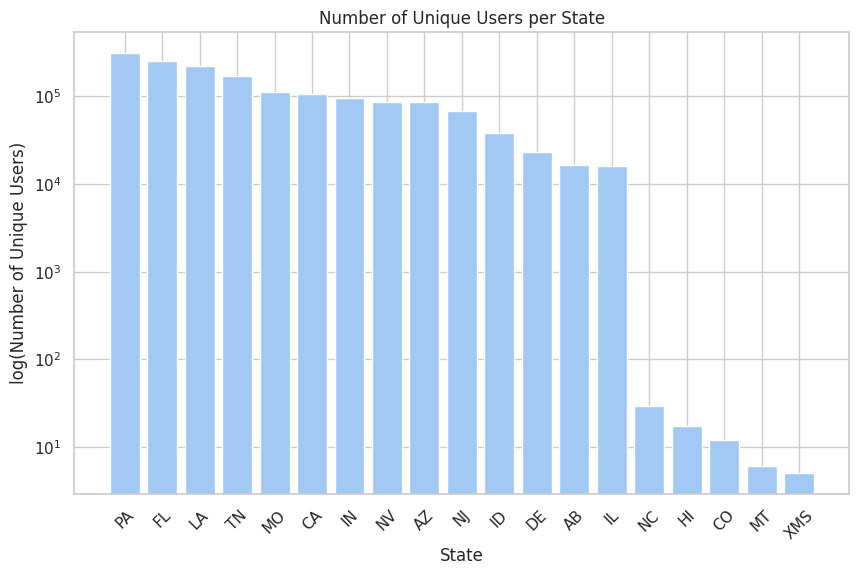

In [38]:
plt.figure(figsize=(10, 6))
plt.bar(pandas_df['state'], pandas_df['unique_users'])
plt.yscale('log')
plt.xlabel('State')
plt.ylabel('log(Number of Unique Users)')
plt.title('Number of Unique Users per State')
plt.xticks(rotation=45)
plt.show()

## Categories Distribution

In [ ]:
# Split the categories column into separate columns
categories_df = businesses.withColumn('categories', F.split(businesses['categories'], ', '))

# Convert the DataFrame to a Pandas DataFrame
pandas_df = categories_df.toPandas()

# Flatten the categories into a single column
categories = [item for sublist in pandas_df['categories'] for item in sublist]

# Create a Pandas DataFrame with the category counts
category_counts = pd.Series(categories).value_counts()

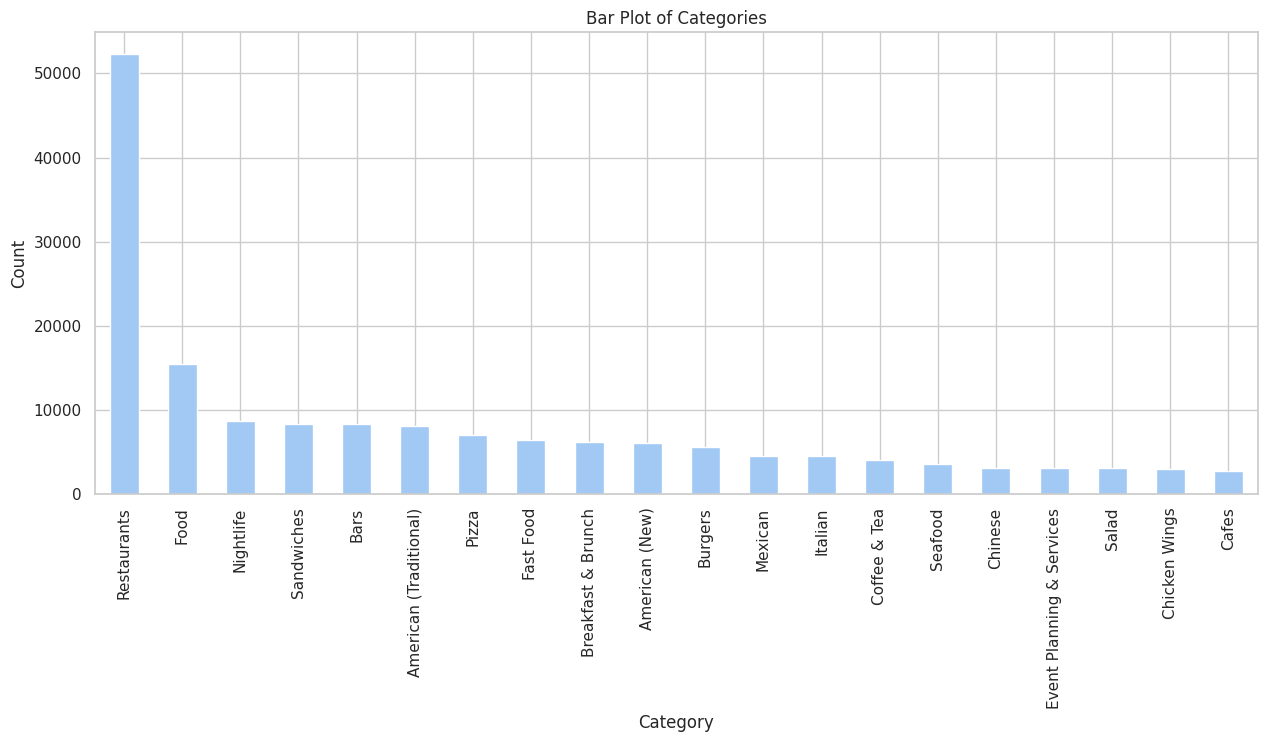

In [34]:
# Create top 20 categories bar plot
plt.figure(figsize=(15, 6))
category_counts[:20].plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Bar Plot of Categories')
plt.xticks(rotation=90)
plt.show()

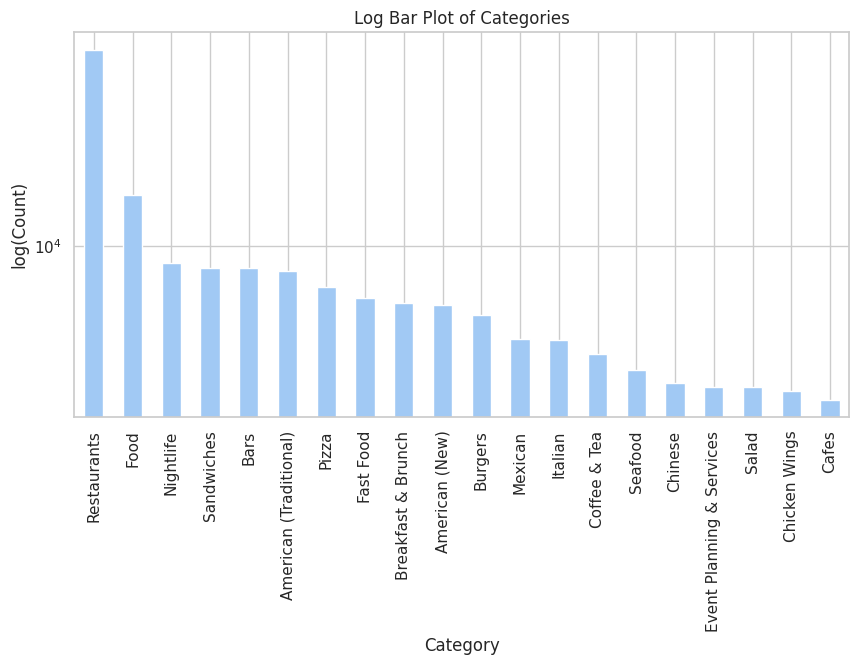

In [33]:
# Create top 20 categories bar plot (Log Plot)
plt.figure(figsize=(10, 5))
category_counts[:20].plot(kind='bar')
plt.yscale('log')
plt.xlabel('Category')
plt.ylabel('log(Count)')
plt.title('Log Bar Plot of Categories')
plt.xticks(rotation=90)
plt.show()

In [20]:
# Unique Categories
len(set(categories))

728

In [14]:
category_counts

Restaurants                  52268
Food                         15472
Nightlife                     8723
Sandwiches                    8366
Bars                          8337
                             ...  
Home Theatre Installation        1
Homeowner Association            1
Kids Hair Salons                 1
Calabrian                        1
Gemstones & Minerals             1
Length: 728, dtype: int64

## Open Businesses

In [ ]:
# businesses.select(F.col("city")).distinct().collect()

In [40]:
businesses_open = businesses.groupBy('is_open').count().toPandas()
businesses_open

,is_open,count
0,0,17281
1,1,34987


<Axes: xlabel='is_open', ylabel='count'>

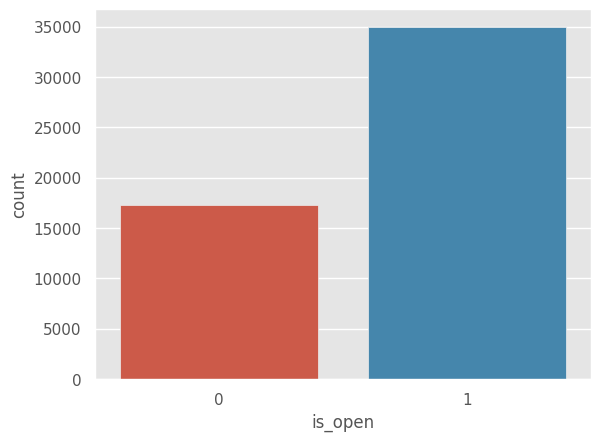

In [41]:
# sns.set_style('white')
plt.style.use('ggplot')
sns.barplot(x='is_open', y='count', data=businesses_open)

### Selecting Only Open Businesses

In [42]:
df = df.filter(F.col("is_open").contains("1"))

##**Distribution of review_count:**

In [43]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

users.select("review_count").groupBy().agg(F.mean("review_count").alias("mean_review_count"), 
                                         F.max("review_count").alias("max_review_count"), 
                                         F.min("review_count").alias("min_review_count")).show()

+------------------+----------------+----------------+
| mean_review_count|max_review_count|min_review_count|
+------------------+----------------+----------------+
|23.394409267683386|           17473|               0|
+------------------+----------------+----------------+



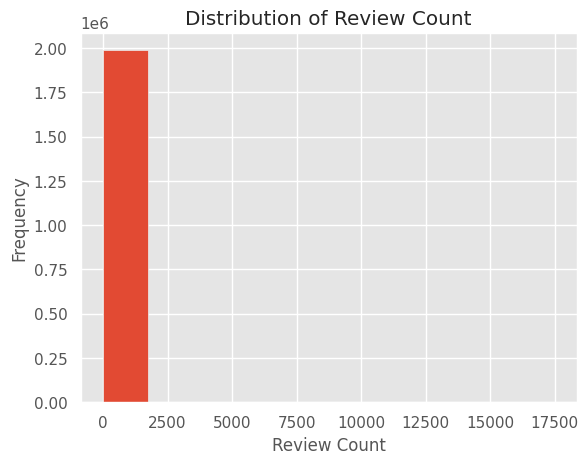

In [44]:
users.select("review_count").toPandas().hist()
plt.xlabel("Review Count")
plt.ylabel("Frequency")
plt.title("Distribution of Review Count")
plt.show()

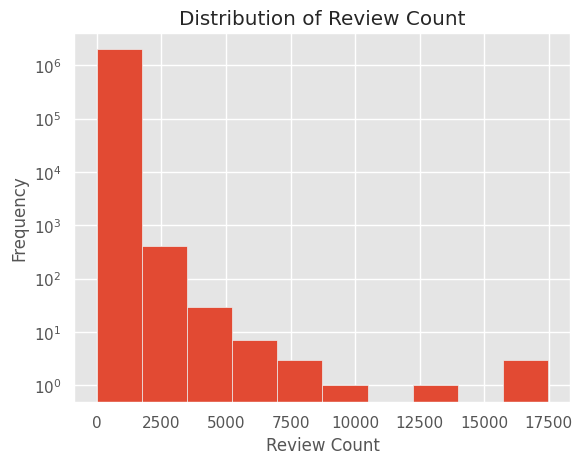

In [45]:
users.select("review_count").toPandas().hist()
plt.yscale('log')
plt.xlabel("Review Count")
plt.ylabel("Frequency")
plt.title("Distribution of Review Count")
plt.show()

##**Top 10 users with the most reviews:**

In [46]:
users.groupBy("user_name", "user_id").agg(F.sum("review_count").alias("total_reviews")).orderBy(F.desc("total_reviews")).show(10)

+---------+--------------------+-------------+
|user_name|             user_id|total_reviews|
+---------+--------------------+-------------+
|      Fox|Hi10sGSZNxQH3NLyW...|        17473|
|   Victor|8k3aO-mPeyhbR5HUu...|        16978|
|    Bruce|hWDybu_KvYLSdEFzG...|        16567|
|    Shila|RtGqdDBvvBCjcu5dU...|        12868|
|      Kim|P5bUL3Engv-2z6kKo...|         9941|
|   Nijole|nmdkHL2JKFx55T3nq...|         8363|
|  Vincent|bQCHF5rn5lMI9c5kE...|         8354|
|   George|8RcEwGrFIgkt9WQ35...|         7738|
|  Kenneth|Xwnf20FKuikiHcSpc...|         6766|
| Jennifer|CxDOIDnH8gp9KXzpB...|         6679|
+---------+--------------------+-------------+
only showing top 10 rows



##**Histograms for average stars**

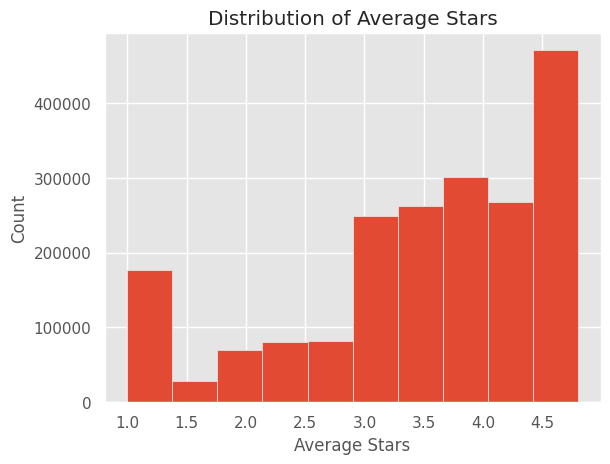

In [47]:
histogram = users.select('average_stars').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(histogram[0][:-1], weights=histogram[1])
plt.title('Distribution of Average Stars')
plt.xlabel('Average Stars')
plt.ylabel('Count')
plt.show()

## Users VS Businesses

In [35]:
selected_df = businesses.select('business_id', 'Restaurant_name', 'Restaurant_stars', 'Restaurant_review_count', 'state')

In [36]:
filtered_df = businesses.filter(businesses['state'] == 'PA')

In [39]:
from pyspark.sql.functions import avg, count, max, min

grouped_df = businesses.groupBy('state').agg(avg('Restaurant_stars'), count('business_id'))
max_review_count = businesses.groupBy('state').agg(max('Restaurant_review_count'))

In [40]:
grouped_df

DataFrame[state: string, avg(Restaurant_stars): double, count(business_id): bigint]

In [41]:
max_review_count

DataFrame[state: string, max(Restaurant_review_count): bigint]

In [46]:
joined_df = reviews.join(businesses, 'business_id', 'inner')

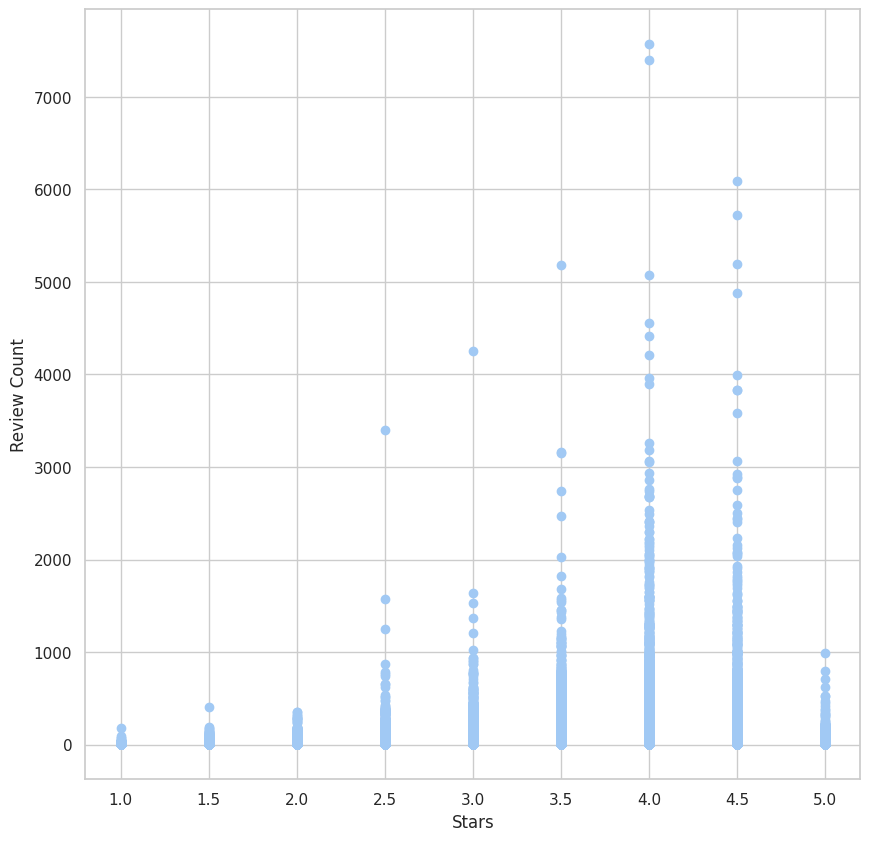

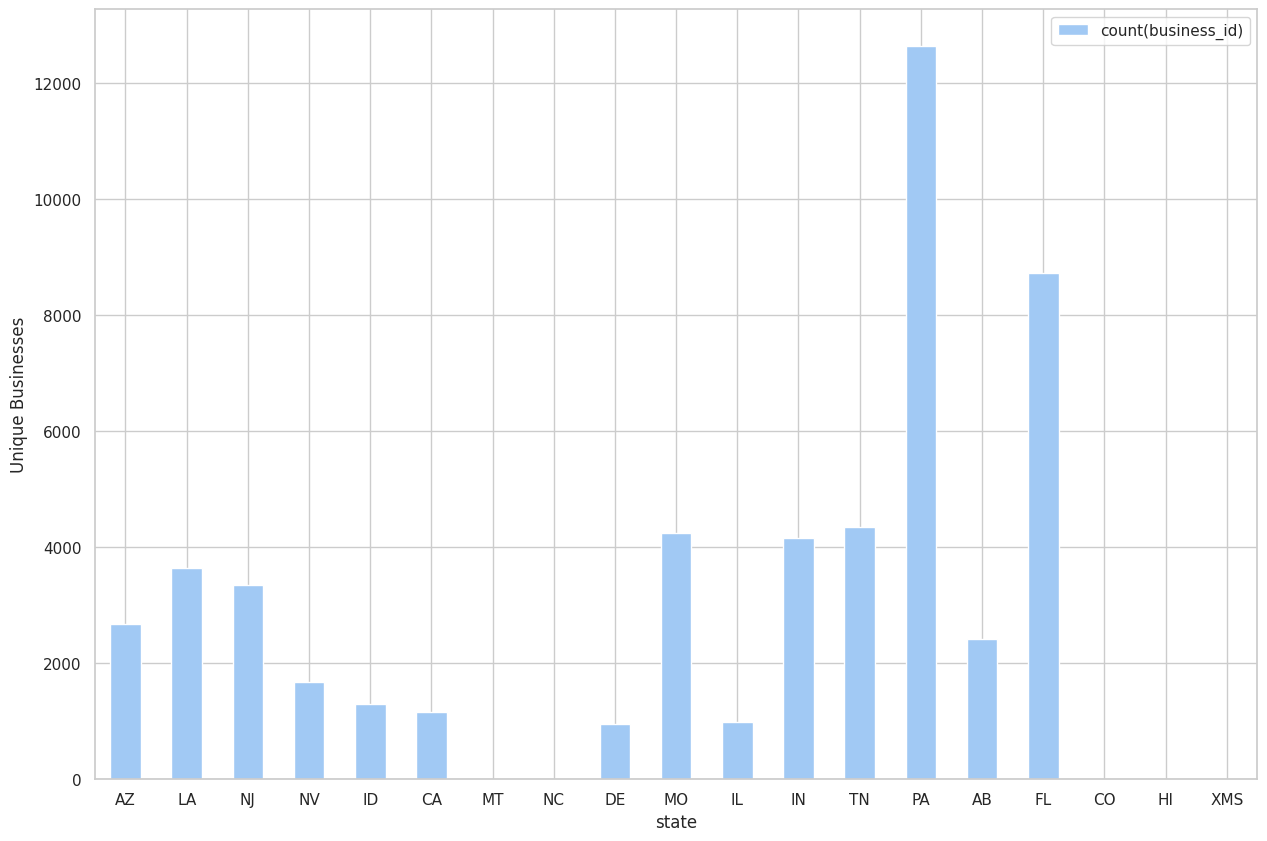

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

selected_df_pd = selected_df.toPandas()

plt.figure(figsize=(10,10))
plt.scatter(selected_df_pd['Restaurant_stars'], selected_df_pd['Restaurant_review_count'])
plt.xlabel('Stars')
plt.ylabel('Review Count')
plt.show()

grouped_df_pd = grouped_df.toPandas()
# plt.figure(figsize=(10,10))
grouped_df_pd.plot.bar(x='state', y='count(business_id)', rot=0, figsize=(15,10))
plt.ylabel('Unique Businesses')
plt.show()


## **Open businesses counts by state (Top 10)**

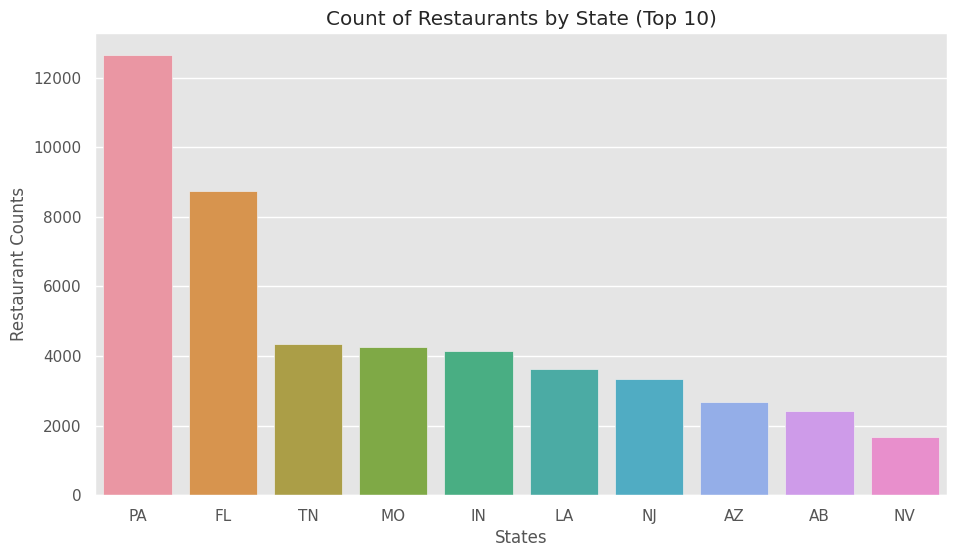

In [51]:
business_counts = businesses.groupBy('state').count().sort('count').orderBy(['count'], ascending=[0]).toPandas()
plt.figure(figsize=(11,6))
states = business_counts['state'].values[:10]
counts = business_counts['count'].values[:10]
sns.barplot(x = states, y = counts)
plt.ylabel('Restaurant Counts')
plt.xlabel('States')
plt.title('Count of Restaurants by State (Top 10)')
plt.show()

In [52]:
business_counts.head()

,state,count
0,PA,12641
1,FL,8731
2,TN,4352
3,MO,4247
4,IN,4150


### By average count

In [50]:
state_avg = businesses.groupBy('city','state').count().groupBy('state').agg({'count':'avg'}).sort(F.desc('avg(count)')).toPandas()
state_avg = state_avg.round(0)
state_avg.head()

,state,avg(count)
0,AB,161.0
1,NV,152.0
2,AZ,148.0
3,CA,145.0
4,ID,145.0


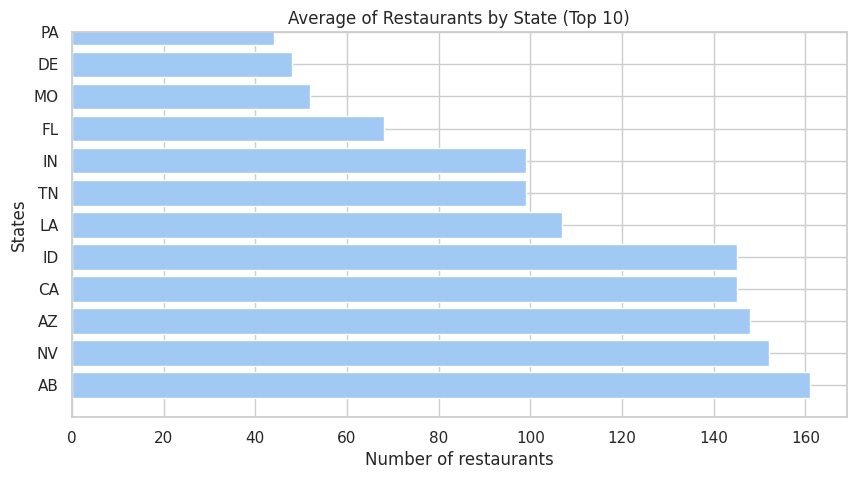

In [51]:
plt.figure(figsize=(10,5))
plt.barh(state_avg.state.values, state_avg['avg(count)'])
# sns.barplot(x=state_avg.state.values, y=state_avg['avg(count)'], orient='h')
plt.title("Average of Restaurants by State (Top 10)")
plt.xlabel("Number of restaurants")
plt.ylabel("States")
plt.ylim((-1,11))
plt.show()

### By City

In [55]:
business_counts_city = businesses.groupBy('city').count().sort('count').orderBy(['count'], ascending=[0]).toPandas()
business_counts_city.head()

,city,count
0,Philadelphia,5852
1,Tampa,2960
2,Indianapolis,2862
3,Nashville,2502
4,Tucson,2466


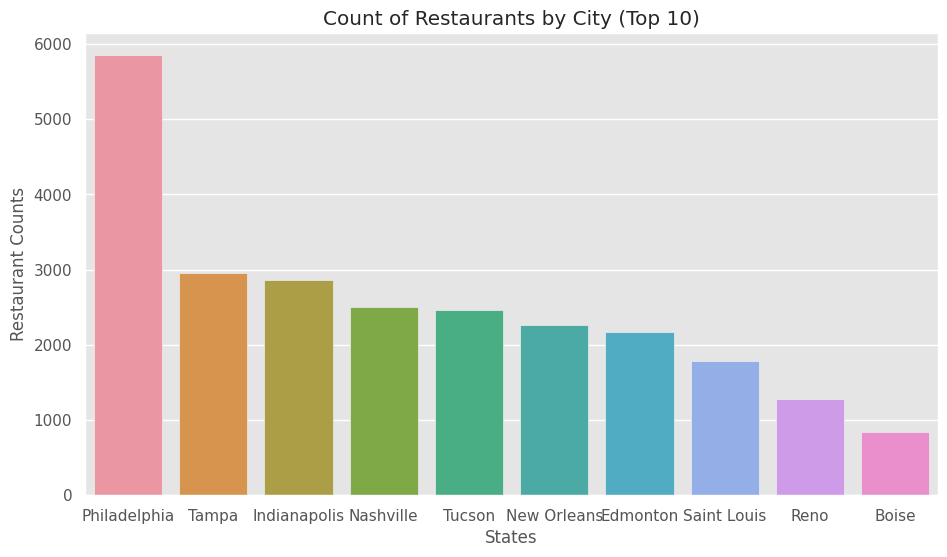

In [56]:
plt.figure(figsize=(11,6))
states = business_counts_city['city'].values[:10]
counts = business_counts_city['count'].values[:10]
sns.barplot(x = states, y = counts)
plt.ylabel('Restaurant Counts')
plt.xlabel('States')
plt.title('Count of Restaurants by City (Top 10)')
plt.show()

Based on the information above, Pennsylvania state has the highest count of restaurants, and among the top 10 cities in the USA with the most restaurants, Philadelphia stands out significantly. Additionally, on average, Alberta has a greater number of restaurants per city compared to other states.

## Reviews distribution over time

In [57]:
df.count()

3769692

In [58]:
reviews_res = df.groupBy('year').count().orderBy('count').toPandas()
reviews_res = reviews_res.dropna()
reviews_res.head()

,year,count
0,2005,399
1,2006,1757
2,2007,6553
3,2008,19742
4,2022,20445


Text(0.5, 1.0, 'Total reviews recieved over time')

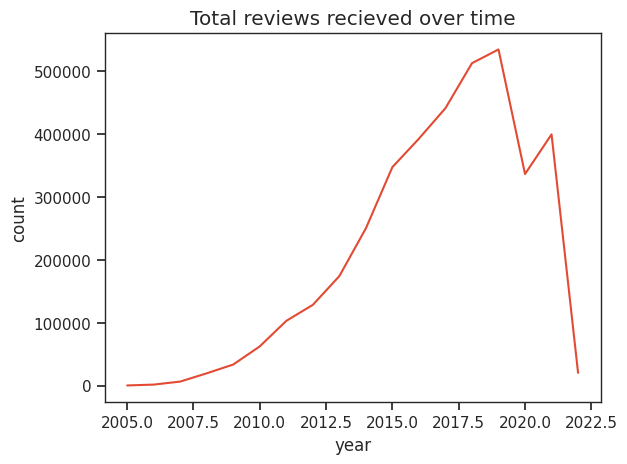

In [59]:
sns.set_style('ticks')
sns.lineplot(x="year", y="count", data=reviews_res).set_title('Total reviews recieved over time')

Based on the data provided in the dataset, it appears that 2017 had the highest number of received reviews. Additionally, there was exponential growth in the number of reviews from 2010 to 2016. One possibility is that there was an increase in the use of online review platforms, which may have made it easier for people to leave reviews. This could have resulted in a higher volume of reviews overall, and particularly in 2017 when the platform may have reached peak popularity.

However, we can observe a steep decrease in the reviews as of 2019, this could be because of COVID-19 when people stater of avoid going out and started to social distance.

## **Stars per state**

In [60]:
state_df = df.groupBy('state', 'stars').count().orderBy('count').toPandas()
state_df['stars'] = state_df.stars.astype(int)

In [61]:
top_restaurant = state_df.sort_values(by=['count'], ascending = False).head(50)
top_restaurant = top_restaurant.pivot(index = 'state', columns = 'stars', values = 'count')
top_restaurant = top_restaurant.dropna()

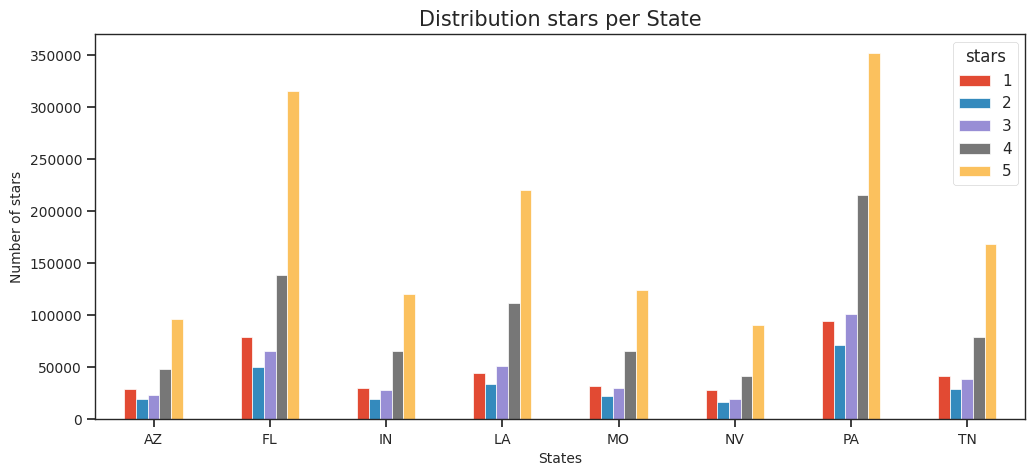

In [62]:
top_restaurant.plot.bar(figsize=(12,5))
plt.ylabel("Number of stars", fontsize = 10)
plt.xlabel("States", fontsize = 10)
plt.title("Distribution stars per State", fontsize = 15)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.xticks(rotation = 0)
plt.show()

According to the data, Pensilvania (PA) received the largest number of 5-star ratings, with Florida (FL) coming in second place. These results are consistent with the proportion of restaurants per state that we observed earlier.

## **Top 10 Resteraunts with 5 Stars**

In [63]:
stars_df = df.groupBy('stars', 'Restaurant_name').count().orderBy('count').toPandas()
stars_df['stars'] = stars_df.stars.astype(int)

In [64]:
top_restaurant = stars_df[stars_df['stars']==5].sort_values(by=['count'], ascending = False).head(10)
top_restaurant = top_restaurant.pivot(index = 'Restaurant_name', columns = 'stars', values = 'count')

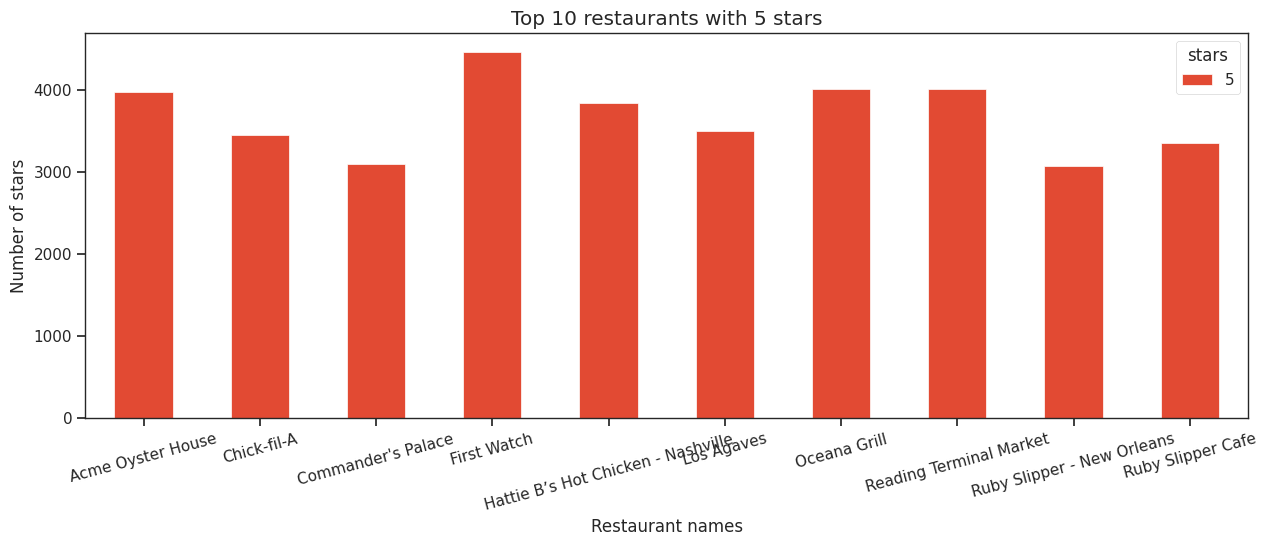

In [65]:
top_restaurant.plot.bar(figsize=(15,5))
plt.ylabel("Number of stars")
plt.xlabel("Restaurant names")
plt.title("Top 10 restaurants with 5 stars")
plt.xticks(rotation=15)
plt.show()

In [66]:
# Top 15 in PA 
data = df.filter(F.col('state')=='PA')
stars_df = data.groupBy('Restaurant_name').count().orderBy('count').toPandas()
# stars_df['review_count'] = stars_df.review_count.astype(int)
top_restaurant = stars_df.sort_values(by=['count'], ascending = False).head(15)

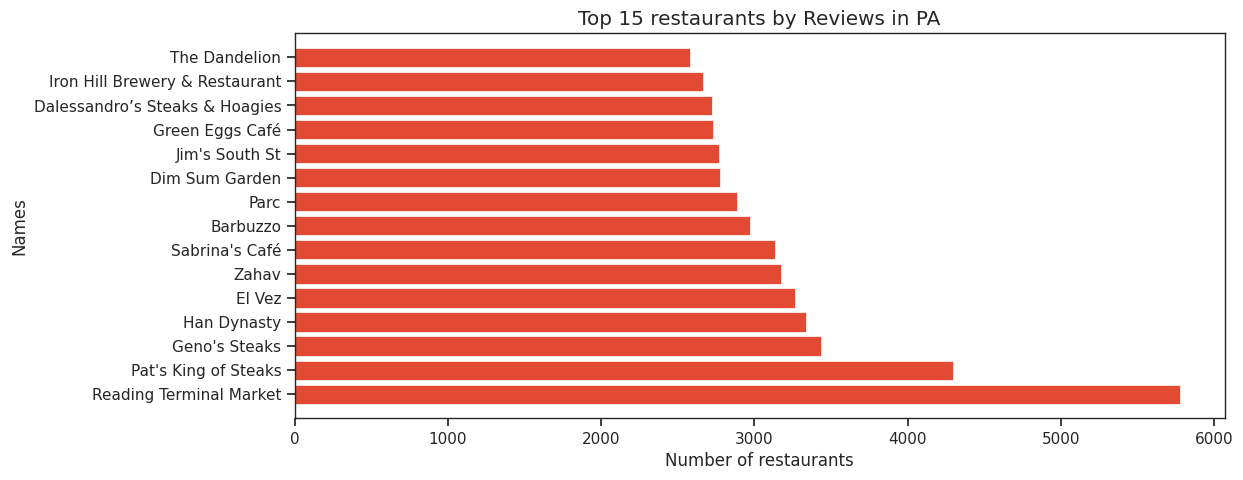

In [67]:
plt.figure(figsize=(12,5))
plt.barh(top_restaurant.Restaurant_name, top_restaurant['count'])
plt.title("Top 15 restaurants by Reviews in PA")
plt.xlabel("Number of restaurants")
plt.ylabel("Names")
plt.ylim((-1,15))
plt.show()

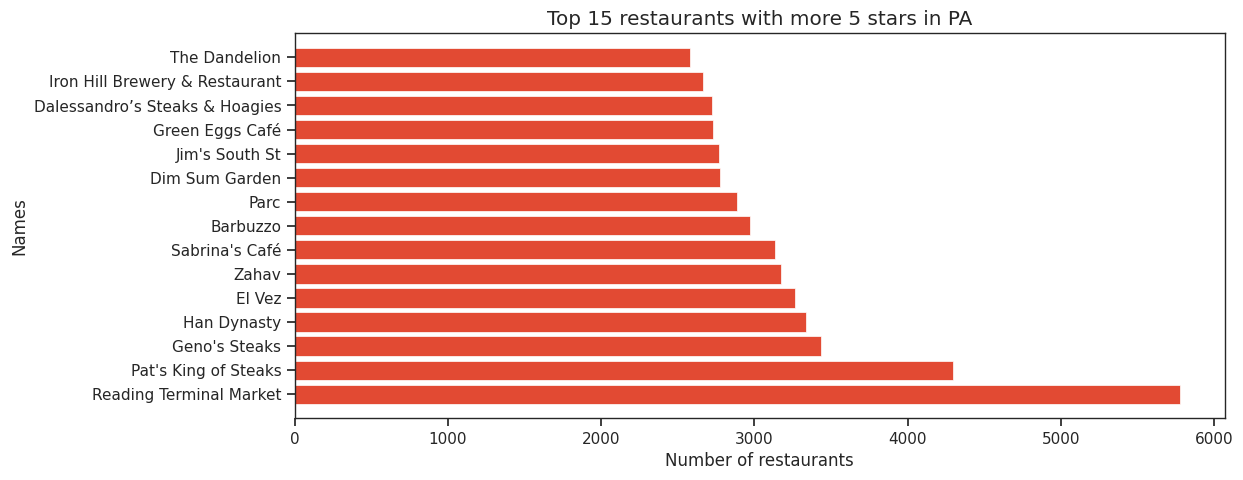

In [68]:

plt.figure(figsize=(12,5))
plt.barh(top_restaurant.Restaurant_name, top_restaurant['count'])
plt.title("Top 15 restaurants with more 5 stars in PA")
plt.xlabel("Number of restaurants")
plt.ylabel("Names")
plt.ylim((-1,15))
plt.show()

## Top 2 Resterauntes in PA Trend over time

In [69]:
# Top 4: Trend over time (this cell takes 15 mins to execute)
top_1 = df.filter(df.Restaurant_name == 'Reading Terminal Market').groupBy('year').count().orderBy('count').toPandas()
top_2 = df.filter(df.Restaurant_name == 'Zahav').groupBy('year').count().orderBy('count').toPandas()
# top_3 = df.filter(df.Restaurant_name == "Dalessandro's Steak & Hoagies").groupBy('year').count().orderBy('count').toPandas()
# top_4 = df.filter(df.Restaurant_name == 'Barbuzzo').groupBy('year').count().orderBy('count').toPandas()

Text(0.5, 1.0, 'Zahav')

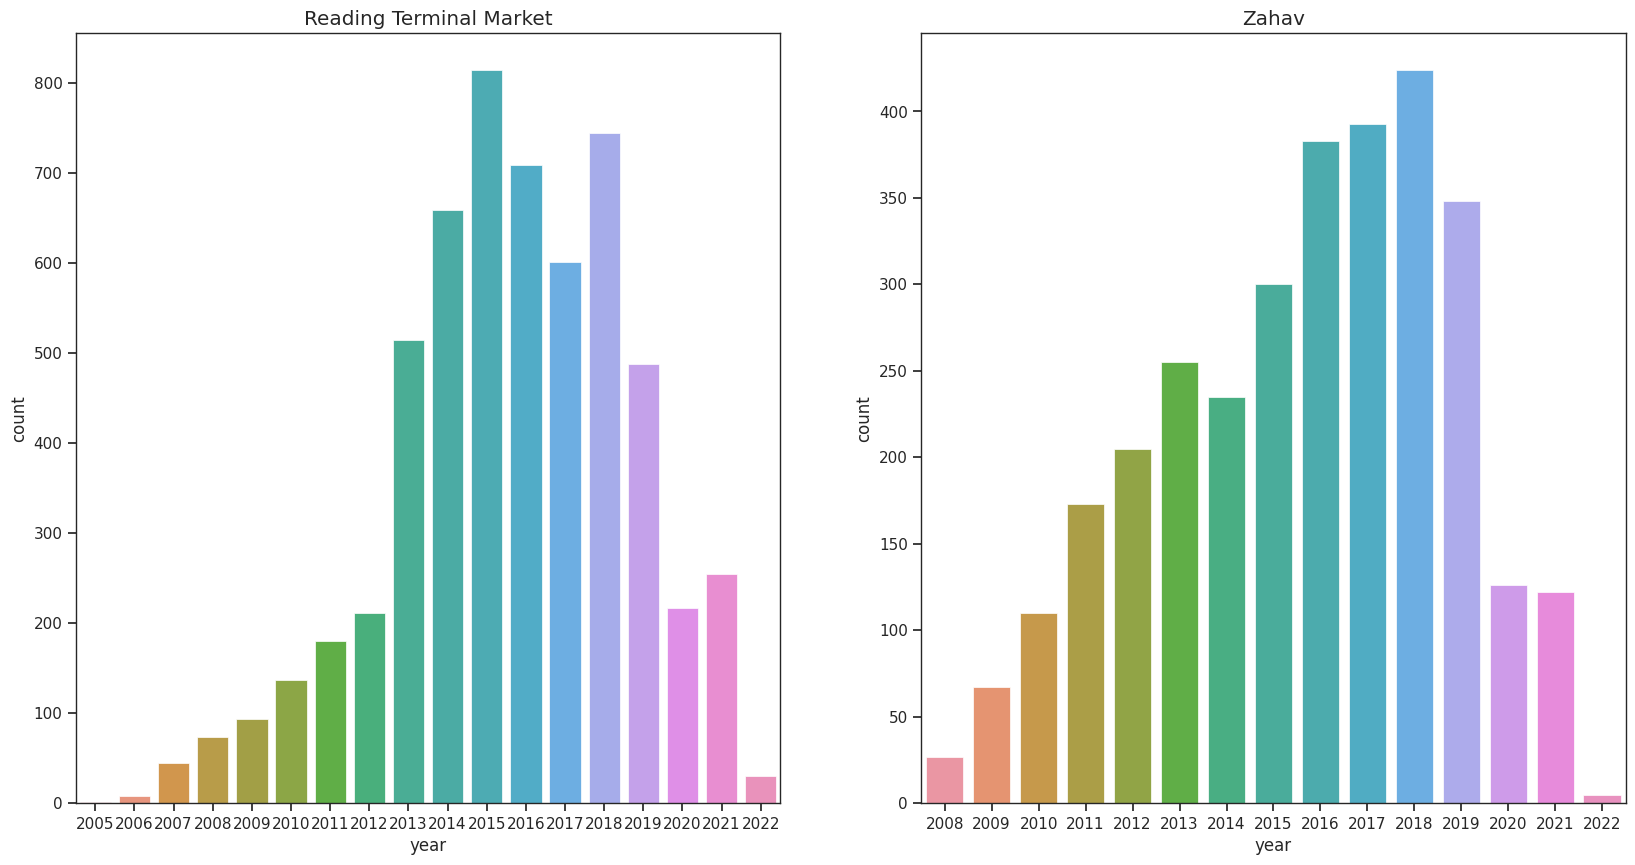

In [76]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.barplot(x="year", y="count", data=top_1).set_title('Reading Terminal Market')

plt.subplot(1,2,2)
sns.barplot(x="year", y="count", data=top_2).set_title('Zahav')

# plt.subplot(2,2,3)
# sns.barplot(x="year", y="count", data=top_3).set_title("Dalessandro's Steak & Hoagies")

# plt.subplot(2,2,4)
# sns.barplot(x="year", y="count", data=top_4).set_title('Barbuzzo')

## Worst Restaurants

In [79]:
stars_df = df.groupBy('stars', 'Restaurant_name').count().orderBy('count').toPandas()
stars_df['stars'] = stars_df.stars.astype(int)
top_restaurant = stars_df[stars_df['stars']==1].sort_values(by=['count'], ascending = False).head(15)

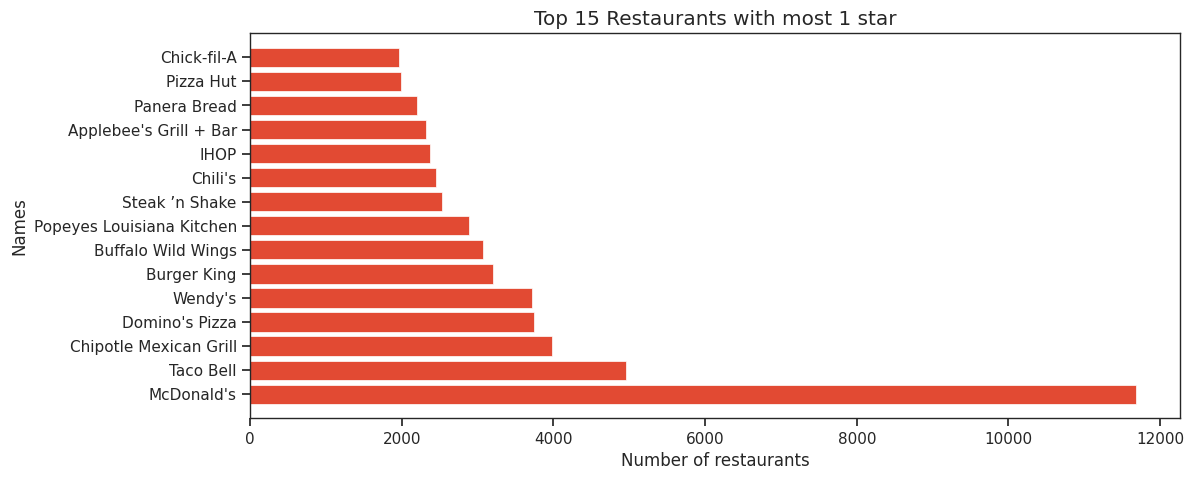

In [80]:
plt.figure(figsize=(12,5))
plt.barh(top_restaurant.Restaurant_name, top_restaurant['count'])
plt.title("Top 15 Restaurants with most 1 star")
plt.xlabel("Number of restaurants")
plt.ylabel("Names")
plt.ylim((-1,15))
plt.show()

## Top 10 users with most reviews

In [81]:
df_user = df.groupBy('user_name', 'user_id').count().sort(F.desc('count')).toPandas()
df_user = df_user.head(10)

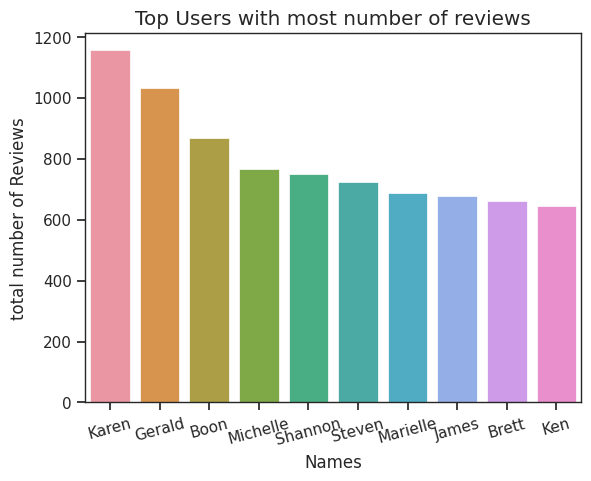

In [82]:
plt.figure()
sns.barplot(x='user_name', y='count', data=df_user)
plt.title("Top Users with most number of reviews")
plt.xlabel("Names")
plt.ylabel("total number of Reviews")
plt.xticks(rotation=15)
plt.show()

# Word Cloud Based on Reviews

In [83]:
punct_remover = F.udf(lambda x: remove_punctuations(x))

In [84]:
import string
def remove_punctuations(text):
    punctuations = set(string.punctuation)
    no_punct_text = ''.join(char.lower() for char in text if char not in punctuations)
    return no_punct_text

In [85]:
df_word = df.select('*', punct_remover('text')).drop('text')
df_word = df_word.withColumnRenamed('<lambda>(text)', 'text')

In [86]:
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [87]:
word_visual =df_word.select('text').limit(100000).toPandas()

In [88]:
text = " ".join(review for review in word_visual.text)

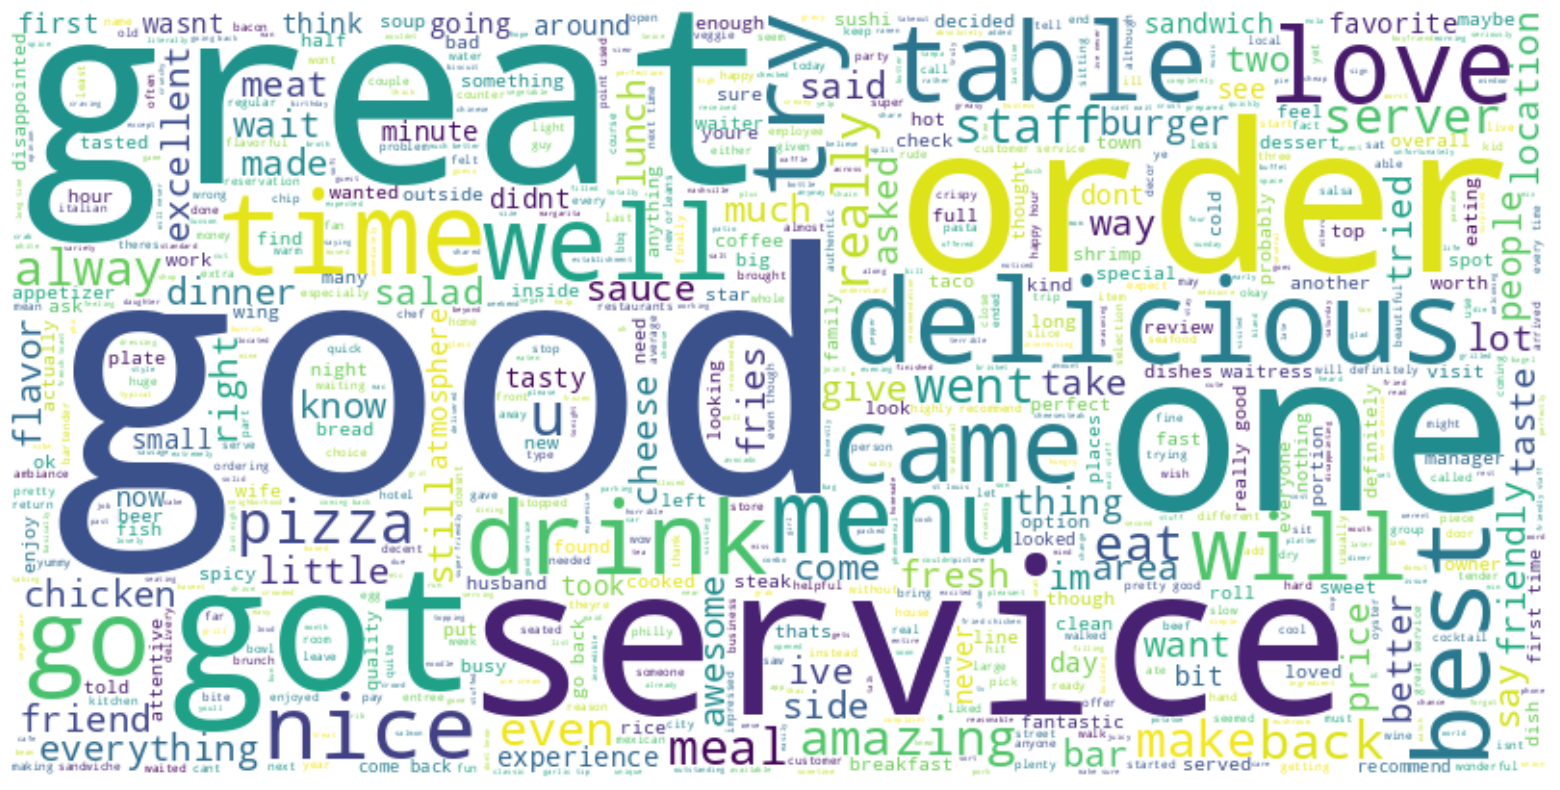

In [89]:
plt.figure(figsize = (20,10))
stopwords = set(STOPWORDS)
stopwords.update(["place", "food", "ordered","restaurant"])
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=1000,width=800, height=400).generate(text[:10000000])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()